In [29]:
import sys

assert sys.version_info >= (3, 7)


In [30]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [31]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [118]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]
np.random.seed(42)   #This ensures the test and training set remains the same
train_set, test_set = shuffle_and_split_data(housing, 0.2)
#test_set.head()

In [33]:
from zlib import crc32  #The zlib library is used for lossless compression, but has many other uses

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]
housing_with_id = housing.reset_index()  # adds an `index` column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")
#housing_with_id.head()
train_set.head()

housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

In [34]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [35]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [36]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])
    
strat_train_set, strat_test_set = strat_splits[0]

In [37]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [38]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()



In [39]:
housing_cat = housing[["ocean_proximity"]]
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [40]:
cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown)
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown),
                         columns=cat_encoder.get_feature_names_out(),
                         index=df_test_unknown.index)


In [41]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
housing_num = housing.select_dtypes(include=[np.number])
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)


std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

In [42]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

In [43]:
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = ElasticNet()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]  # pretend this is new data

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions.reshape(-1, 1))



In [46]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(ElasticNet(),
                                   transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [47]:
def monkey_patch_get_signature_names_out():
    """Monkey patch some classes which did not handle get_feature_names_out()
       correctly in Scikit-Learn 1.0.*."""
    from inspect import Signature, signature, Parameter
    import pandas as pd
    from sklearn.impute import SimpleImputer
    from sklearn.pipeline import make_pipeline, Pipeline
    from sklearn.preprocessing import FunctionTransformer, StandardScaler

    default_get_feature_names_out = StandardScaler.get_feature_names_out

    if not hasattr(SimpleImputer, "get_feature_names_out"):
      print("Monkey-patching SimpleImputer.get_feature_names_out()")
      SimpleImputer.get_feature_names_out = default_get_feature_names_out

    if not hasattr(FunctionTransformer, "get_feature_names_out"):
        print("Monkey-patching FunctionTransformer.get_feature_names_out()")
        orig_init = FunctionTransformer.__init__
        orig_sig = signature(orig_init)

        def __init__(*args, feature_names_out=None, **kwargs):
            orig_sig.bind(*args, **kwargs)
            orig_init(*args, **kwargs)
            args[0].feature_names_out = feature_names_out

        __init__.__signature__ = Signature(
            list(signature(orig_init).parameters.values()) + [
                Parameter("feature_names_out", Parameter.KEYWORD_ONLY)])

        def get_feature_names_out(self, names=None):
            if callable(self.feature_names_out):
                return self.feature_names_out(self, names)
            assert self.feature_names_out == "one-to-one"
            return default_get_feature_names_out(self, names)

        FunctionTransformer.__init__ = __init__
        FunctionTransformer.get_feature_names_out = get_feature_names_out

monkey_patch_get_signature_names_out()

df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index)



In [48]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

In [49]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

housing_prepared = preprocessing.fit_transform(housing)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [ ]:
from sklearn.preprocessing import FunctionTransformer, StandardScaler
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn import set_config


num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])


num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

set_config(display='diagram')


In [82]:
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import make_pipeline

alpha=0.1
l1_ratio=0.5
elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)

pipeline = make_pipeline(preprocessing, elastic_net)

pipeline.fit(housing, housing_labels)
housing_predictions = pipeline.predict(housing)
housing_predictions[:5].round(-2) 

array([233100., 370200., 112900.,  90800., 294500.])

In [85]:
housing_labels.iloc[:5].values

from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)
lin_rmse

71603.21676099156

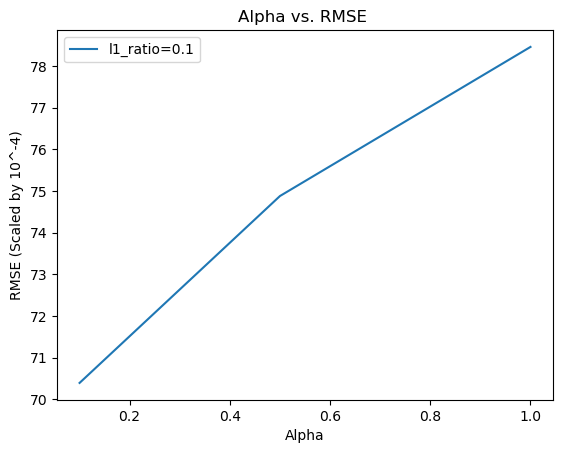

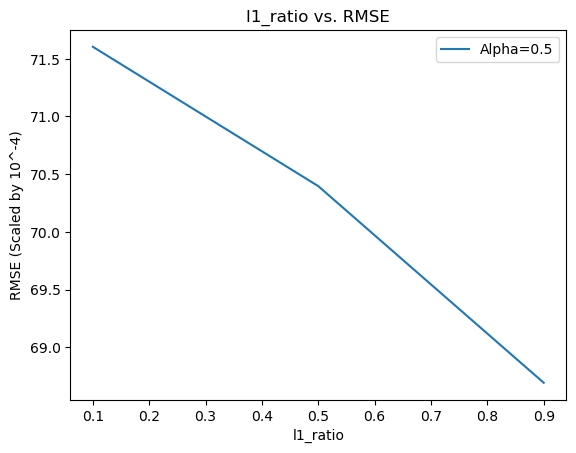

In [106]:
import matplotlib.pyplot as plt

alphas = [0.1, 0.5, 1.0]
l1_ratios = [0.1, 0.5, 0.9]

rmse_alpha = []
rmse_l1 = []

for alpha in alphas:
        elastic_net = ElasticNet(alpha=alpha, l1_ratio=0.5)
        pipeline = make_pipeline(preprocessing, elastic_net)
        pipeline.fit(housing, housing_labels)
        housing_predictions = pipeline.predict(housing)
        rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
        rmse_alpha.append(rmse*(1/1000))
        
for l1_ratio in l1_ratios:
        elastic_net = ElasticNet(alpha=0.1, l1_ratio=l1_ratio)
        pipeline = make_pipeline(preprocessing, elastic_net)
        pipeline.fit(housing, housing_labels)
        housing_predictions = pipeline.predict(housing)
        rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
        rmse_l1.append(rmse*(1/1000))



plt.figure()
plt.plot(alphas, rmse_alpha, label=f'l1_ratio={0.1}')
plt.xlabel('Alpha')
plt.ylabel('RMSE (Scaled by 10^-4)')
plt.title('Alpha vs. RMSE ')
plt.legend()
plt.show()

plt.figure()
plt.plot(l1_ratios, rmse_l1, label=f'Alpha={0.5}')
plt.xlabel('l1_ratio')
plt.ylabel('RMSE (Scaled by 10^-4)')
plt.title('l1_ratio vs. RMSE')
plt.legend()
plt.show()

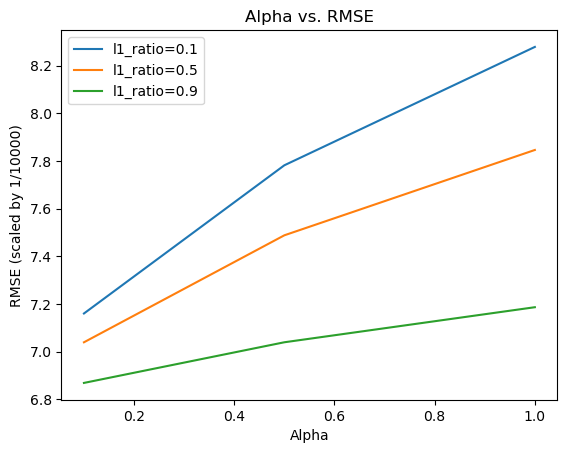

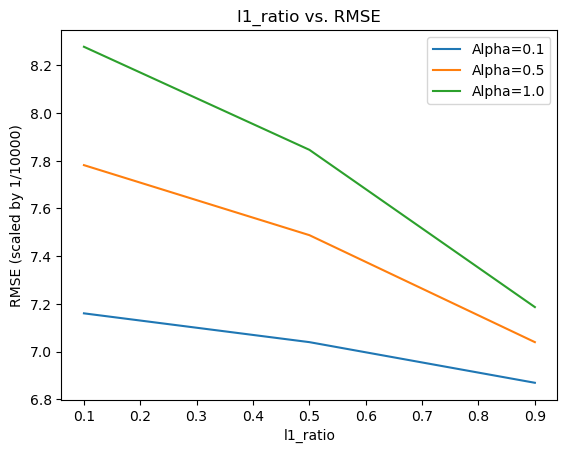

In [116]:
import matplotlib.pyplot as plt

alphas = [0.1, 0.5, 1.0]
l1_ratios = [0.1, 0.5, 0.9]

rmse_values = []

for alpha in alphas:
    for l1_ratio in l1_ratios:
        elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
        pipeline = make_pipeline(preprocessing, elastic_net)
        pipeline.fit(housing, housing_labels)
        housing_predictions = pipeline.predict(housing)
        rmse = mean_squared_error(housing_labels, housing_predictions, squared=False) / 10000  # Scale by 1/10000
        rmse_values.append((alpha, l1_ratio, rmse))

rmse_values = np.array(rmse_values)


plt.figure()
for l1_ratio in l1_ratios:
    rmse_vals = [entry[2] for entry in rmse_values if entry[1] == l1_ratio]
    plt.plot(alphas, rmse_vals, label=f'l1_ratio={l1_ratio}')
plt.xlabel('Alpha')
plt.ylabel('RMSE (scaled by 1/10000)')
plt.title('Alpha vs. RMSE')
plt.legend()
plt.show()

plt.figure()
for alpha in alphas:
    rmse_vals = [entry[2] for entry in rmse_values if entry[0] == alpha]
    plt.plot(l1_ratios, rmse_vals, label=f'Alpha={alpha}')
plt.xlabel('l1_ratio')
plt.ylabel('RMSE (scaled by 1/10000)')
plt.title('l1_ratio vs. RMSE')
plt.legend()
plt.show()